# Data 400
## Mini Project - Impact of Big Market Status on NBA Betting Odds
### Pham Duy Anh Vu

*__________________________________________________________________________________________________________________________*

   The explosion of legalized sports betting across the U.S., following the 2018 Supreme Court decision to strike down the Professional and Amateur Sports Protection Act (PASPA), has led to a dramatic surge in sports betting participation. According to reports, over half of American adults have placed a sports bet since legalization, contributing to a market now worth over $93 billion annually (CNN Sport, 2024). The NBA has become one of the focal points of this booming industry, with billions of dollars wagered each season on its games. Given the magnitude of financial stakes and the growing accessibility of betting platforms, understanding the dynamics of market inefficiencies in NBA betting lines is more critical than ever. However, one prominent inefficiency is the **“big-market”** status of a team. 
   
   In the NBA, team popularity, market size, and media attention vary widely between teams. As a result, the perception of **“big-market”** teams often influences public sentiment. These **big-market** teams (typically characterized by higher valuations, larger fan bases, and extensive media coverage) are more visible and may attract a disproportionate share of bets. This raises a crucial question: Does the **big-market** status of an NBA team skew betting odds? 


###

In [1]:
import os
os.chdir(r'C:\Users\vupha\OneDrive - Dickinson College\Data400_Spring25\ideas\Mini Project 1')

#### 1. Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy import stats

C:\Users\vupha\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
!pip install sweetviz ydata_profiling

import ydata_profiling as pp
import sweetviz as sv

In [4]:
pip install --upgrade openpyxl

Note: you may need to restart the kernel to use updated packages.


#### 2. Setting up the dataset

In [5]:
# NBA Betting Odds data
odds = pd.read_excel('Data\importable_oddsData.xlsx')
odds

# NBA Games data
oct = pd.read_excel('Data\importable_sportsref_nba2122_oct.xlsx')
nov = pd.read_excel('Data\importable_sportsref_nba2122_nov.xlsx')
dec = pd.read_excel('Data\importable_sportsref_nba2122_dec.xlsx')
jan = pd.read_excel('Data\importable_sportsref_nba2122_jan.xlsx')
feb = pd.read_excel('Data\importable_sportsref_nba2122_feb.xlsx')
mar = pd.read_excel('Data\importable_sportsref_nba2122_mar.xlsx')
apr = pd.read_excel('Data\importable_sportsref_nba2122_apr.xlsx')

In [6]:
# Concatenating all the NBA games into one dataset
games = pd.concat([oct, nov, dec, jan, feb, mar, apr])
games.head()

Date Start (ET)        Visitor/Neutral  PTS        Home/Neutral  \
0 2021-10-19      7:30p          Brooklyn Nets  104     Milwaukee Bucks   
1 2021-10-19     10:00p  Golden State Warriors  121  Los Angeles Lakers   
2 2021-10-20      7:00p         Indiana Pacers  122   Charlotte Hornets   
3 2021-10-20      7:00p          Chicago Bulls   94     Detroit Pistons   
4 2021-10-20      7:30p         Boston Celtics  134     New York Knicks   

   PTS.1 Unnamed: 6 Unnamed: 7  Attend.       LOG                       Arena  \
0    127  Box Score        NaN  17341.0  02:20:00                Fiserv Forum   
1    114  Box Score        NaN  18997.0  02:33:00            Crypto.com Arena   
2    123  Box Score        NaN  15521.0  02:20:00             Spectrum Center   
3     88  Box Score        NaN  20088.0  02:09:00        Little Caesars Arena   
4    138  Box Score        2OT  19812.0  02:54:00  Madison Square Garden (IV)   

   Notes  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN

In [7]:
odds.head()

Date  season         team home/visitor      opponent  score  \
0 2007-10-30    2008         Utah            @  Golden State    117   
1 2007-10-30    2008    LA Lakers           vs       Houston     93   
2 2007-10-30    2008      Houston            @     LA Lakers     95   
3 2007-10-30    2008  San Antonio           vs      Portland    106   
4 2007-10-30    2008     Portland            @   San Antonio     97   

   opponentScore  moneyLine  opponentMoneyLine  total  spread  secondHalfTotal  
0             96      100.0             -120.0  212.0     1.0            105.5  
1             95      190.0             -230.0  199.0     5.0             99.0  
2             93     -230.0              190.0  199.0    -5.0             99.0  
3             97    -1400.0              900.0  189.5   -13.0             95.0  
4            106      900.0            -1400.0  189.5    13.0             95.0

In [8]:
# Filtering all odds data to only include odds from the NBA 2021-2022 season
odds['Date'] = pd.to_datetime(odds['Date'])
odds = odds[(odds['Date'] >= '2021-10-19') & (odds['Date'] <= '2022-04-10')]
odds.head()

Date  season          team home/visitor      opponent  score  \
33316 2021-10-19    2022     Milwaukee           vs      Brooklyn    127   
33317 2021-10-19    2022     LA Lakers           vs  Golden State    114   
33318 2021-10-19    2022  Golden State            @     LA Lakers    121   
33319 2021-10-19    2022      Brooklyn            @     Milwaukee    104   
33320 2021-10-20    2022      New York           vs        Boston    138   

       opponentScore  moneyLine  opponentMoneyLine  total  spread  \
33316            104     -125.0              105.0  233.5    -1.5   
33317            121     -160.0              140.0  226.5    -3.5   
33318            114      140.0             -160.0  226.5     3.5   
33319            127      105.0             -125.0  233.5     1.5   
33320            134     -140.0              120.0  220.0    -2.5   

       secondHalfTotal  
33316            114.0  
33317            111.5  
33318            111.5  
33319            114.0  
33320            112.5

In [9]:
# Standardize team names for merging
games['merge_team'] = games['Home/Neutral'].str.replace(r' [^ ]+$', '', regex = True)
games.loc[games['merge_team'] == 'Los Angeles Lakers', 'merge_team'] = 'LA Lakers'
games.loc[games['merge_team'] == 'Los Angeles Clippers', 'merge_team'] = 'LA Clippers'
games.loc[games['merge_team'] == 'Portland Trail', 'merge_team'] = 'Portland'

odds['merge_team'] = np.where(odds['home/visitor'] == 'vs', odds['team'], np.where(odds['home/visitor'] == '@', odds['team'], np.nan))

In [10]:
# Merge datasets on date and teams
data = pd.merge(games, odds, on = ['Date', 'merge_team'], how = 'inner')
data.head()

Date Start (ET)     Visitor/Neutral  PTS       Home/Neutral  PTS.1  \
0 2021-10-19      7:30p       Brooklyn Nets  104    Milwaukee Bucks    127   
1 2021-10-20      7:00p      Indiana Pacers  122  Charlotte Hornets    123   
2 2021-10-20      7:00p       Chicago Bulls   94    Detroit Pistons     88   
3 2021-10-20      7:30p      Boston Celtics  134    New York Knicks    138   
4 2021-10-20      7:30p  Washington Wizards   98    Toronto Raptors     83   

  Unnamed: 6 Unnamed: 7  Attend.       LOG  ...       team  home/visitor  \
0  Box Score        NaN  17341.0  02:20:00  ...  Milwaukee            vs   
1  Box Score        NaN  15521.0  02:20:00  ...  Charlotte            vs   
2  Box Score        NaN  20088.0  02:09:00  ...    Detroit            vs   
3  Box Score        2OT  19812.0  02:54:00  ...   New York            vs   
4  Box Score        NaN  19800.0  02:15:00  ...    Toronto            vs   

     opponent  score opponentScore moneyLine opponentMoneyLine  total  spread  \
0    Brooklyn    127           104    -125.0             105.0  233.5    -1.5   
1     Indiana    123           122     105.0            -125.0  223.0     1.5   
2     Chicago     88            94     190.0            -220.0  218.0     5.0   
3      Boston    138           134    -140.0             120.0  220.0    -2.5   
4  Washington     83            98    -140.0             120.0  223.0    -2.5   

   secondHalfTotal  
0            114.0  
1            110.5  
2            110.5  
3            112.5  
4            109.0  

[5 rows x 24 columns]

In [11]:
# Drop unmatched data
data = data.dropna(subset=['moneyLine', 'merge_team'])
data.head()

Date Start (ET)     Visitor/Neutral  PTS       Home/Neutral  PTS.1  \
0 2021-10-19      7:30p       Brooklyn Nets  104    Milwaukee Bucks    127   
1 2021-10-20      7:00p      Indiana Pacers  122  Charlotte Hornets    123   
2 2021-10-20      7:00p       Chicago Bulls   94    Detroit Pistons     88   
3 2021-10-20      7:30p      Boston Celtics  134    New York Knicks    138   
4 2021-10-20      7:30p  Washington Wizards   98    Toronto Raptors     83   

  Unnamed: 6 Unnamed: 7  Attend.       LOG  ...       team  home/visitor  \
0  Box Score        NaN  17341.0  02:20:00  ...  Milwaukee            vs   
1  Box Score        NaN  15521.0  02:20:00  ...  Charlotte            vs   
2  Box Score        NaN  20088.0  02:09:00  ...    Detroit            vs   
3  Box Score        2OT  19812.0  02:54:00  ...   New York            vs   
4  Box Score        NaN  19800.0  02:15:00  ...    Toronto            vs   

     opponent  score opponentScore moneyLine opponentMoneyLine  total  spread  \
0    Brooklyn    127           104    -125.0             105.0  233.5    -1.5   
1     Indiana    123           122     105.0            -125.0  223.0     1.5   
2     Chicago     88            94     190.0            -220.0  218.0     5.0   
3      Boston    138           134    -140.0             120.0  220.0    -2.5   
4  Washington     83            98    -140.0             120.0  223.0    -2.5   

   secondHalfTotal  
0            114.0  
1            110.5  
2            110.5  
3            112.5  
4            109.0  

[5 rows x 24 columns]

In [12]:
# Categorize teams into big, medium, and small markets using standardized names
market_mapping = {
    "Golden State": "Big", "New York": "Big", "LA Lakers": "Big", "Boston": "Big", "LA Clippers": "Big", "Chicago": "Big", "Dallas": "Big", "Houston": "Big", "Philadelphia": "Big", "Toronto": "Big",
    "Phoenix": "Medium", "Miami": "Medium", "Brooklyn": "Medium", "Washington": "Medium", "Denver": "Medium", "Milwaukee": "Medium", "Portland": "Medium", "Cleveland": "Medium", "Sacramento": "Medium", "Utah": "Medium",
    "San Antonio": "Small", "Atlanta": "Small", "Oklahoma City": "Small", "Orlando": "Small", "Indiana": "Small", "Charlotte": "Small", "Minnesota": "Small", "Memphis": "Small", "New Orleans": "Small", "Detroit": "Small"
}

data['home_market'] = data['team'].map(market_mapping).fillna('Small')
data['opponent_market'] = data['opponent'].map(market_mapping).fillna('Small')
data.head()

Date Start (ET)     Visitor/Neutral  PTS       Home/Neutral  PTS.1  \
0 2021-10-19      7:30p       Brooklyn Nets  104    Milwaukee Bucks    127   
1 2021-10-20      7:00p      Indiana Pacers  122  Charlotte Hornets    123   
2 2021-10-20      7:00p       Chicago Bulls   94    Detroit Pistons     88   
3 2021-10-20      7:30p      Boston Celtics  134    New York Knicks    138   
4 2021-10-20      7:30p  Washington Wizards   98    Toronto Raptors     83   

  Unnamed: 6 Unnamed: 7  Attend.       LOG  ...    opponent  score  \
0  Box Score        NaN  17341.0  02:20:00  ...    Brooklyn    127   
1  Box Score        NaN  15521.0  02:20:00  ...     Indiana    123   
2  Box Score        NaN  20088.0  02:09:00  ...     Chicago     88   
3  Box Score        2OT  19812.0  02:54:00  ...      Boston    138   
4  Box Score        NaN  19800.0  02:15:00  ...  Washington     83   

  opponentScore  moneyLine opponentMoneyLine  total spread  secondHalfTotal  \
0           104     -125.0             105.0  233.5   -1.5            114.0   
1           122      105.0            -125.0  223.0    1.5            110.5   
2            94      190.0            -220.0  218.0    5.0            110.5   
3           134     -140.0             120.0  220.0   -2.5            112.5   
4            98     -140.0             120.0  223.0   -2.5            109.0   

   home_market  opponent_market  
0       Medium           Medium  
1        Small            Small  
2        Small              Big  
3          Big              Big  
4          Big           Medium  

[5 rows x 26 columns]

In [13]:
# Perform ANOVA test
anova_results = stats.f_oneway(
    data[data['home_market'] == 'Big']['moneyLine'],
    data[data['home_market'] == 'Medium']['moneyLine'],
    data[data['home_market'] == 'Small']['moneyLine']
)
print("ANOVA test results:")
print("F-statistic:", anova_results.statistic)
print("P-value:", anova_results.pvalue)

ANOVA test results:
F-statistic: 36.34972469808376
P-value: 4.947984605459845e-16


In [14]:
# Encode market size variables
data = pd.get_dummies(data, columns=['home_market', 'opponent_market'])
data.head()

Date Start (ET)     Visitor/Neutral  PTS       Home/Neutral  PTS.1  \
0 2021-10-19      7:30p       Brooklyn Nets  104    Milwaukee Bucks    127   
1 2021-10-20      7:00p      Indiana Pacers  122  Charlotte Hornets    123   
2 2021-10-20      7:00p       Chicago Bulls   94    Detroit Pistons     88   
3 2021-10-20      7:30p      Boston Celtics  134    New York Knicks    138   
4 2021-10-20      7:30p  Washington Wizards   98    Toronto Raptors     83   

  Unnamed: 6 Unnamed: 7  Attend.       LOG  ... opponentMoneyLine  total  \
0  Box Score        NaN  17341.0  02:20:00  ...             105.0  233.5   
1  Box Score        NaN  15521.0  02:20:00  ...            -125.0  223.0   
2  Box Score        NaN  20088.0  02:09:00  ...            -220.0  218.0   
3  Box Score        2OT  19812.0  02:54:00  ...             120.0  220.0   
4  Box Score        NaN  19800.0  02:15:00  ...             120.0  223.0   

  spread  secondHalfTotal home_market_Big home_market_Medium  \
0   -1.5            114.0           False               True   
1    1.5            110.5           False              False   
2    5.0            110.5           False              False   
3   -2.5            112.5            True              False   
4   -2.5            109.0            True              False   

  home_market_Small  opponent_market_Big  opponent_market_Medium  \
0             False                False                    True   
1              True                False                   False   
2              True                 True                   False   
3             False                 True                   False   
4             False                False                    True   

   opponent_market_Small  
0                  False  
1                   True  
2                  False  
3                  False  
4                  False  

[5 rows x 30 columns]

In [15]:
# Drop unnecessary data
data = data.drop(columns=['Date', 'Start (ET)', 'PTS', 'PTS.1', 'Unnamed: 6', 'Unnamed: 7', 'Attend.', 'LOG', 'Arena', 'Notes', 'merge_team', 'season', 'team', 'home/visitor', 'opponent'])
data.head()

Visitor/Neutral       Home/Neutral  score  opponentScore  moneyLine  \
0       Brooklyn Nets    Milwaukee Bucks    127            104     -125.0   
1      Indiana Pacers  Charlotte Hornets    123            122      105.0   
2       Chicago Bulls    Detroit Pistons     88             94      190.0   
3      Boston Celtics    New York Knicks    138            134     -140.0   
4  Washington Wizards    Toronto Raptors     83             98     -140.0   

   opponentMoneyLine  total  spread  secondHalfTotal  home_market_Big  \
0              105.0  233.5    -1.5            114.0            False   
1             -125.0  223.0     1.5            110.5            False   
2             -220.0  218.0     5.0            110.5            False   
3              120.0  220.0    -2.5            112.5             True   
4              120.0  223.0    -2.5            109.0             True   

   home_market_Medium  home_market_Small  opponent_market_Big  \
0                True              False                False   
1               False               True                False   
2               False               True                 True   
3               False              False                 True   
4               False              False                False   

   opponent_market_Medium  opponent_market_Small  
0                    True                  False  
1                   False                   True  
2                   False                  False  
3                   False                  False  
4                    True                  False

#### 3. Regression

In [16]:
# Remove non-numeric columns before fitting the model
X = data.select_dtypes(include=[np.number]).drop(columns=['moneyLine'], errors='ignore')
y = data['moneyLine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Model Evaluation
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

Mean Absolute Error: 83.29689198522642
R2 Score: 0.9071757879727805


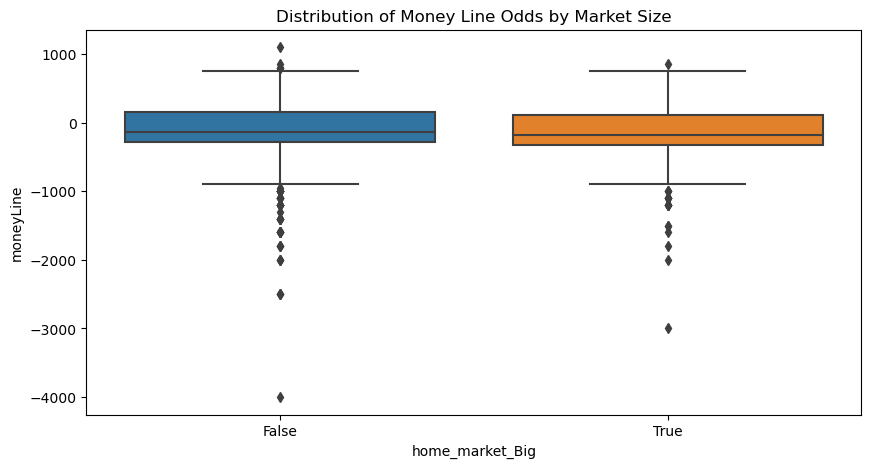

In [17]:
# Data Visualization
plt.figure(figsize=(10, 5))
sns.boxplot(x='home_market_Big', y='moneyLine', data=data)
plt.title("Distribution of Money Line Odds by Market Size")
plt.show()

In [18]:
# Pandas Profiling
pp.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
# SweetViz
report = sv.analyze(data)

                                             |          | [  0%]   00:00 -> (? left)

In [20]:
report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
